# The first ML model to find false positives in AF PPI preditions
Created 2025-01-10

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import sklearn
import pickle
import re

In [2]:
# First creating the human readable dataset
measureAF = pd.read_csv(Path("../ressources//af_structures.csv"))
measureSolved = pd.read_csv(Path("../ressources//solved_structures.csv"))
predictionAF = pd.read_excel(Path("../ressources/ISS AF_DMI_structures/AF_prediction_randomized_DMI_results.xlsx"))

measureAF["file"] = measureAF["file"].str.replace(".pdb", "")
measureSolved["file"] = measureSolved["file"].str.replace(".pdb", "")

measureSolved.index = measureSolved.apply(lambda row: row["structure_name"].split("_")[0], axis=1)
measureAF.index = measureAF["structure_name"] + "_" + measureAF["file"]
predictionAF.index = predictionAF["prediction_name"] + "_" + predictionAF["model_id"]


dataAF = pd.merge(
    left=predictionAF,
    right=measureAF, 
    how='inner',
    left_index=True,
    right_index=True
    #left_on=['prediction_name', 'model_id'],
    #right_on=['structure_name', 'file'],
)
dataAF.drop(columns=["structure_name", "file"], inplace=True)
dataAF["solved structure"] = dataAF.apply(lambda row: None if not (r := re.search(r"^([\w_]+)_([\w]{4})$", row["prediction_name"])) or len(r.groups()) != 2 else r.groups()[1], axis=1)
display(dataAF)


if len(measureAF) > len(dataAF):
    print(f"{len(measureAF) - len(dataAF)} structures not found in the predictionAF excel sheet")


# Data preperation

# NaN value problem in min_distance
# Try as first a very naive approach: Replace them with 20
dataAF["min_distance"] = dataAF["min_distance"].fillna(value=20)

X = dataAF[["model_confidence", "chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", 
            "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions",
            "num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "num_atom_atom_contact", "chainA_length", "chainB_length"]]
Y = dataAF[["label"]]
print("NaN values in dataset X")
display(X[X.isnull().any(axis=1)])
#X.index = dataAF["structure_name"] + "_" + dataAF["file"]
#Y.index = dataAF["structure_name"] + "_" + dataAF["file"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2501)
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

display(X)
display(Y)

,prediction_name,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,...,num_res_res_contact,num_atom_atom_contact,num_mutation_in_motif,label,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,solved structure
DEG_APCC_KENBOX_2_4GGD_ranked_0,DEG_APCC_KENBOX_2_4GGD,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,0.162263,3.311542,...,23,208,known minimal,1,9,0,613.651,6.063,0,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_1,DEG_APCC_KENBOX_2_4GGD,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,0.145001,3.395909,...,20,190,known minimal,1,9,0,580.310,6.083,0,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_2,DEG_APCC_KENBOX_2_4GGD,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,0.116743,6.166772,...,27,237,known minimal,1,10,0,662.104,6.072,3,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_3,DEG_APCC_KENBOX_2_4GGD,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,0.036380,16.713730,...,11,83,known minimal,1,2,0,398.498,5.417,0,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_4,DEG_APCC_KENBOX_2_4GGD,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,0.029969,18.696838,...,9,108,known minimal,1,2,0,323.304,5.092,9,4GGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_0,MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3,312,4,ranked_0,0.680386,94.414615,40.943334,84.388750,0.038101,6.028506,...,14,60,random minimal,0,0,0,585.345,6.220,25,None
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_1,MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3,312,4,ranked_1,0.674241,89.304167,38.329999,79.109334,0.062945,6.435163,...,15,108,random minimal,0,1,2,567.373,5.664,23,None
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_2,MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3,312,4,ranked_2,0.670584,90.133333,37.503333,76.975833,0.055375,6.313079,...,11,117,random minimal,0,3,2,589.111,5.396,12,None
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_3,MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3,312,4,ranked_3,0.635099,87.795000,36.423333,77.520667,0.043403,6.988881,...,14,110,random minimal,0,4,2,584.961,6.929,9,None


10 structures not found in the predictionAF excel sheet
NaN values in dataset X


,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length


Training set shape: (1065, 17)
Test set shape: (267, 17)


,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
DEG_APCC_KENBOX_2_4GGD_ranked_0,0.887117,96.107999,77.495999,91.454999,0.162263,3.311542,613.651,6.063,9,0,0,15,5,23,208,312,5
DEG_APCC_KENBOX_2_4GGD_ranked_1,0.871984,95.793846,73.986000,89.736111,0.145001,3.395909,580.310,6.083,9,0,0,13,5,20,190,312,5
DEG_APCC_KENBOX_2_4GGD_ranked_2,0.760784,95.547501,57.906001,86.585239,0.116743,6.166772,662.104,6.072,10,0,3,16,5,27,237,312,5
DEG_APCC_KENBOX_2_4GGD_ranked_3,0.413662,94.646667,21.510000,76.362500,0.036380,16.713730,398.498,5.417,2,0,0,9,3,11,83,312,5
DEG_APCC_KENBOX_2_4GGD_ranked_4,0.359078,94.830001,19.753333,72.307001,0.029969,18.696838,323.304,5.092,2,0,9,7,3,9,108,312,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_0,0.680386,94.414615,40.943334,84.388750,0.038101,6.028506,585.345,6.220,0,0,25,13,3,14,60,312,4
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_1,0.674241,89.304167,38.329999,79.109334,0.062945,6.435163,567.373,5.664,1,2,23,12,3,15,108,312,4
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_2,0.670584,90.133333,37.503333,76.975833,0.055375,6.313079,589.111,5.396,3,2,12,9,3,11,117,312,4
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_3,0.635099,87.795000,36.423333,77.520667,0.043403,6.988881,584.961,6.929,4,2,9,12,3,14,110,312,4


,label
DEG_APCC_KENBOX_2_4GGD_ranked_0,1
DEG_APCC_KENBOX_2_4GGD_ranked_1,1
DEG_APCC_KENBOX_2_4GGD_ranked_2,1
DEG_APCC_KENBOX_2_4GGD_ranked_3,1
DEG_APCC_KENBOX_2_4GGD_ranked_4,1
...,...
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_0,0
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_1,0
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_2,0
MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3_ranked_3,0


In [3]:
display(x_train)
display(y_train)

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
MLIG_PAM2_2_2X04.DDOC_MAPK_MEF2A_6_4H3Q_ranked_3,0.406334,87.187857,30.447778,64.985218,0.037021,17.972174,841.403,4.888,2,0,24,14,9,25,205,352,14
MDOC_MAPK_JIP1_4_4H3B.DLIG_PAM2_1_1JGN_ranked_3,0.210969,96.027142,28.350000,71.417272,0.031629,19.353260,432.460,6.617,1,0,26,7,4,10,79,73,7
MLIG_14-3-3_ChREBP_3_5F74.DDOC_MAPK_JIP1_4_4H3B_ranked_3,0.362994,83.234166,30.505000,62.142500,0.027997,20.933567,978.833,4.820,3,0,13,12,8,20,211,356,16
MLIG_SH3_2_1CKA.DTRG_NLS_Bipartite_1_1PJM_ranked_2,0.611617,96.802143,33.080000,80.033158,0.060325,9.598278,640.395,4.545,6,1,23,14,5,17,153,460,6
TRG_DiLeu_BaEn_1_4NEE_ranked_2,0.818190,96.705000,85.400002,93.730000,0.215236,2.013762,769.964,4.837,2,0,37,14,5,26,182,142,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRG_NES_CRM1_1_3GB8_ranked_0,0.795128,94.645000,76.777692,87.606364,0.273476,2.075534,1389.344,4.832,5,5,104,20,13,39,275,179,16
MDOC_MAPK_RevD_3_3TEI.DLIG_EF_ALG2_ABM_1_2ZNE_ranked_0,0.386131,88.608800,27.776667,68.879460,0.069784,16.221300,1494.743,4.260,3,2,101,25,12,45,421,168,15
MLIG_LIR_Nem_3_5AZG.DLIG_ULM_U2AF65_1_1O0P_ranked_3,0.669382,93.812000,64.918000,86.588500,0.081375,3.914958,857.152,4.719,4,0,89,15,5,26,273,104,5
MLIG_UFM1_UFIM_1_5HKH.DLIG_KLC1_Yacidic_2_6FUZ_ranked_2,0.654822,94.002727,52.248571,83.924138,0.151285,6.337465,1283.438,5.470,5,5,93,22,7,38,308,223,8


,label
MLIG_PAM2_2_2X04.DDOC_MAPK_MEF2A_6_4H3Q_ranked_3,0
MDOC_MAPK_JIP1_4_4H3B.DLIG_PAM2_1_1JGN_ranked_3,0
MLIG_14-3-3_ChREBP_3_5F74.DDOC_MAPK_JIP1_4_4H3B_ranked_3,0
MLIG_SH3_2_1CKA.DTRG_NLS_Bipartite_1_1PJM_ranked_2,0
TRG_DiLeu_BaEn_1_4NEE_ranked_2,1
...,...
TRG_NES_CRM1_1_3GB8_ranked_0,1
MDOC_MAPK_RevD_3_3TEI.DLIG_EF_ALG2_ABM_1_2ZNE_ranked_0,0
MLIG_LIR_Nem_3_5AZG.DLIG_ULM_U2AF65_1_1O0P_ranked_3,0
MLIG_UFM1_UFIM_1_5HKH.DLIG_KLC1_Yacidic_2_6FUZ_ranked_2,0


## Model training

In [3]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc


def VisualizeModel(model: RandomForestClassifier, x_test, y_test):
    y_pred = model.predict(x_test)
    y_preda = model.predict_proba(x_test)

    score = accuracy_score(y_test, y_pred)
    rocauc_score = roc_auc_score(y_test, y_preda[:, 1])
    print(f"Score: {round(score, 3)}")
    print(f"ROC AUC score: {round(rocauc_score, 3)}")

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm = confusion_matrix(y_test, y_pred)
    imshow_cm = plt.imshow(cm, cmap="Blues")
    plt.colorbar(imshow_cm)
    plt.xticks(range(cm.shape[0]), labels=["Negative", "Positive"])
    plt.yticks(range(cm.shape[1]), labels=["Negative", "Positive"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = "black" if colors.rgb_to_hsv(imshow_cm.cmap(cm[i,j])[:3])[1] < 0.4 else "white"
            text = plt.text(j, i, cm[i, j], ha="center", va="center", color=c)
    plt.show()


    roc_conf_X, roc_conf_Y, _ = roc_curve(y_test, x_test["model_confidence"])
    roc_conf = auc(roc_conf_X, roc_conf_Y)
    roc_model_X, roc_model_Y, _ = roc_curve(y_test, y_preda[:, 1])
    roc_model = auc(roc_model_X, roc_model_Y)

    plt.plot(roc_conf_X, roc_conf_Y, label=f"model confidence (AUC = {roc_conf:.2f})")
    plt.plot(roc_model_X, roc_model_Y, label=f"ml prediction (AUC = {roc_model:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve for Model and Test Subset Features")
    plt.legend(loc="lower right")
    plt.show()

    df = x_test.copy()
    df["label"] = y_test["label"]
    df["prediction"] = y_pred
    df["negative"] = y_preda[:, 0]
    df["positive"] = y_preda[:, 1]

    #df = df[df["label"] != df["prediction"]]
    
    df.sort_values(by=["label", "prediction", "negative"], inplace=True)
    return df

Load model if already trained

D:\Eigene Datein\Programmieren\Git\abrilka\bachelorthesis\models\2025_01_13vA1.model
Score: 0.843
ROC AUC score: 0.927


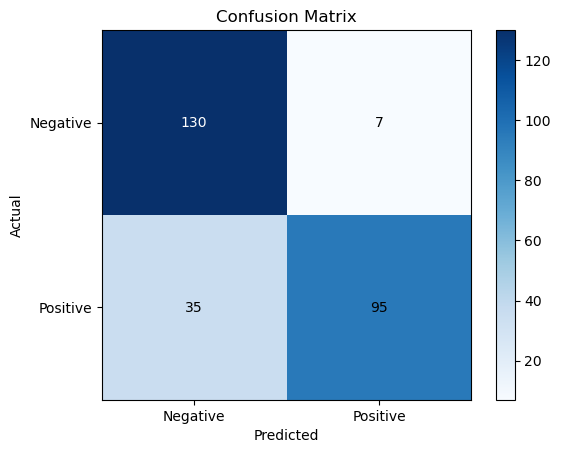

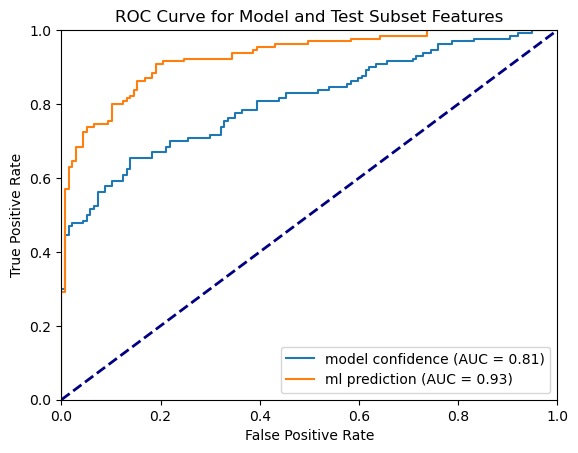

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=6,
                       min_samples_leaf=2, n_estimators=500, random_state=2501)

In [4]:
print(pathModel1 := Path("../models/2025_01_13vA1.model").resolve())
with open(pathModel1, "rb") as f:
    random_search_vA1 = pickle.load(f)
rf_best_vA1 = random_search_vA1.best_estimator_
wrong_predictions_vA1 = VisualizeModel(rf_best_vA1, x_test, y_test)
rf_best_vA1

Train model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Score: 0.843
ROC AUC score: 0.927


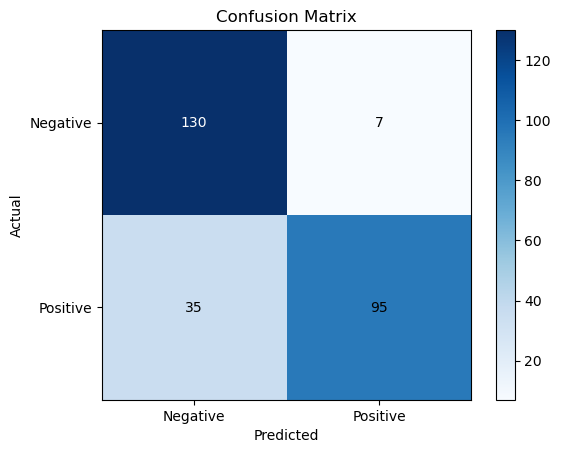

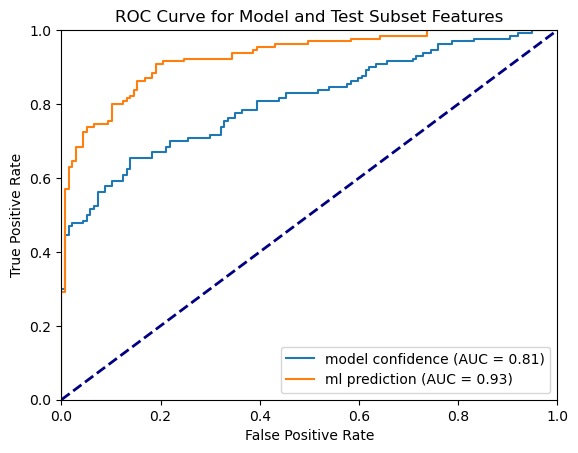

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=6,
                       min_samples_leaf=2, n_estimators=500, random_state=2501)

In [8]:
rf_param_grid_vA1 = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [100, 250, 500],
    "max_depth": [4, 6, 8, 12],
    "min_samples_leaf": [2,3,4,5,10],
    "max_features" : [4,6,8, 10, 12,14]
}

rf_vA1 = RandomForestClassifier(random_state=2501)
random_search_vA1 = RandomizedSearchCV(n_iter=10, estimator=rf_vA1, param_distributions=rf_param_grid_vA1, scoring='accuracy', n_jobs=-1, verbose=2, random_state=2501)
random_search_vA1.fit(x_train, y_train["label"])
rf_best_vA1 = random_search_vA1.best_estimator_
wrong_predictions_vA1 = VisualizeModel(rf_best_vA1, x_test, y_test)
rf_best_vA1

In [9]:
wrong_predictions_vA1

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,...,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length,label,prediction,negative,positive
MLIG_SH3_2_1CKA.DTRG_NLS_Bipartite_1_1PJM_ranked_0,0.672614,96.503333,47.273335,85.563334,0.128674,8.692126,939.403,5.347,5,1,...,21,6,31,250,460,6,0,0,0.506790,0.493210
MLIG_DLG_GKlike_1_3WP0.DTRG_ER_FFAT_1_2RR3_ranked_0,0.708754,95.142143,68.821111,84.842609,0.187396,3.759363,920.748,4.276,4,1,...,14,9,30,223,125,9,0,0,0.510535,0.489465
MDEG_SCF_COI1_1_3OGL.DLIG_CaM_IQ_9_2IX7_ranked_1,0.398070,68.922000,47.594616,61.625789,0.040909,11.977779,1823.567,5.216,10,6,...,25,13,45,384,139,18,0,0,0.518144,0.481856
MLIG_deltaCOP1_diTrp_1_5FJX.DLIG_CAP-Gly_1_2PZO_ranked_2,0.400048,95.422727,62.094999,86.535333,0.093906,4.163994,583.829,4.941,4,0,...,11,4,16,169,46,6,0,0,0.518670,0.481330
MLIG_LIR_Nem_3_5AZG.DLIG_ULM_U2AF65_1_1O0P_ranked_1,0.774361,95.420667,75.908001,90.542500,0.112257,2.783341,859.820,4.750,4,0,...,15,5,25,290,104,5,0,0,0.525542,0.474458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOC_PP1_MyPhoNE_1_1S70_ranked_2,0.608114,91.066000,47.313750,75.847826,0.056849,8.362300,1184.398,4.464,7,1,...,15,8,30,285,299,8,1,1,0.476133,0.523867
LIG_WD40_WDR5_WIN_2_4CY3_ranked_3,0.656029,88.749999,39.466000,79.272307,0.098805,6.204505,990.388,5.490,3,4,...,21,5,32,238,312,7,1,1,0.479977,0.520023
LIG_Clathr_ClatBox_2_1UTC_ranked_1,0.711074,92.944117,55.263334,83.114347,0.093599,5.668848,825.921,5.001,3,1,...,17,6,27,212,328,6,1,1,0.480738,0.519262
LIG_Rb_LxCxE_1_1GH6_ranked_1,0.354527,84.634583,30.665333,63.877179,0.071754,15.188319,1696.524,5.089,5,3,...,24,15,51,442,123,17,1,1,0.487139,0.512861


In [11]:
#Save model
print(pathModel2 := Path("../models/2025_01_13vA1.model").resolve())
with open(pathModel2, "wb") as f:
    pickle.dump(random_search_vA1, f)

D:\Eigene Datein\Programmieren\Git\abrilka\bachelorthesis\models\2025_01_13vA1.model


## Model 2: Normalized measurement values
Normalize hbonds, salt_bridges, min_distance and hydrophobic interactions by dividing by num_res_res_contacts

In [49]:
x_vA2_train = x_train.copy()
x_vA2_test = x_test.copy()

for c in ["hbonds", "salt_bridges", "hydrophobic_interactions"]:
    x_vA2_train[c] = x_train.apply(lambda r: r[c] / r["num_res_res_contact"] if r["num_res_res_contact"] > 0 else 0, axis=1)
    x_vA2_test[c] = x_test.apply(lambda r: r[c] / r["num_res_res_contact"] if r["num_res_res_contact"] > 0 else 0, axis=1)

#x2_train.drop(columns=["chainA_length", "chainB_length"], inplace=True)
#x2_test.drop(columns=["chainA_length", "chainB_length"], inplace=True)

display(x_vA2_train)

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
MLIG_PAM2_2_2X04.DDOC_MAPK_MEF2A_6_4H3Q_ranked_3,0.406334,87.187857,30.447778,64.985218,0.037021,17.972174,841.403,4.888,0.080000,0.000000,0.960000,14,9,25,205,352,14
MDOC_MAPK_JIP1_4_4H3B.DLIG_PAM2_1_1JGN_ranked_3,0.210969,96.027142,28.350000,71.417272,0.031629,19.353260,432.460,6.617,0.100000,0.000000,2.600000,7,4,10,79,73,7
MLIG_14-3-3_ChREBP_3_5F74.DDOC_MAPK_JIP1_4_4H3B_ranked_3,0.362994,83.234166,30.505000,62.142500,0.027997,20.933567,978.833,4.820,0.150000,0.000000,0.650000,12,8,20,211,356,16
MLIG_SH3_2_1CKA.DTRG_NLS_Bipartite_1_1PJM_ranked_2,0.611617,96.802143,33.080000,80.033158,0.060325,9.598278,640.395,4.545,0.352941,0.058824,1.352941,14,5,17,153,460,6
TRG_DiLeu_BaEn_1_4NEE_ranked_2,0.818190,96.705000,85.400002,93.730000,0.215236,2.013762,769.964,4.837,0.076923,0.000000,1.423077,14,5,26,182,142,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRG_NES_CRM1_1_3GB8_ranked_0,0.795128,94.645000,76.777692,87.606364,0.273476,2.075534,1389.344,4.832,0.128205,0.128205,2.666667,20,13,39,275,179,16
MDOC_MAPK_RevD_3_3TEI.DLIG_EF_ALG2_ABM_1_2ZNE_ranked_0,0.386131,88.608800,27.776667,68.879460,0.069784,16.221300,1494.743,4.260,0.066667,0.044444,2.244444,25,12,45,421,168,15
MLIG_LIR_Nem_3_5AZG.DLIG_ULM_U2AF65_1_1O0P_ranked_3,0.669382,93.812000,64.918000,86.588500,0.081375,3.914958,857.152,4.719,0.153846,0.000000,3.423077,15,5,26,273,104,5
MLIG_UFM1_UFIM_1_5HKH.DLIG_KLC1_Yacidic_2_6FUZ_ranked_2,0.654822,94.002727,52.248571,83.924138,0.151285,6.337465,1283.438,5.470,0.131579,0.131579,2.447368,22,7,38,308,223,8


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Score: 0.843
ROC AUC score: 0.93


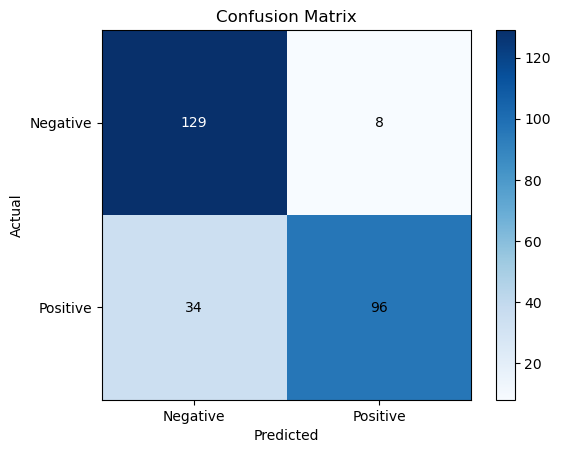

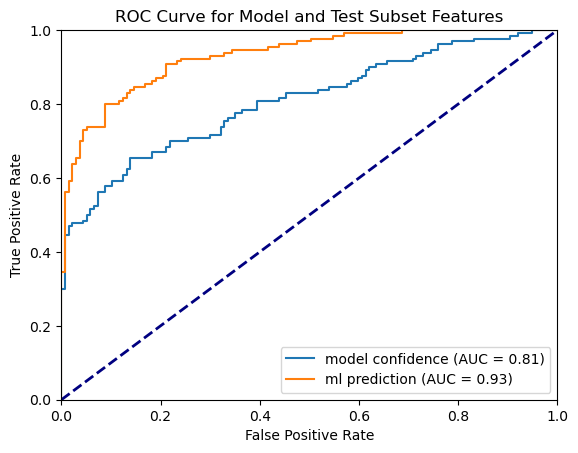

RandomForestClassifier(criterion='log_loss', max_depth=12, max_features=14,
                       min_samples_leaf=2, n_estimators=500, random_state=2501)

In [86]:
rf_param_grid_vA2 = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [100, 250, 500],
    "max_depth": [8,12,16,None],
    "min_samples_leaf": [2,3,4,5,10],
    "max_features" : [10,12, 14, 16]
}

rf_vA2 = RandomForestClassifier(random_state=2501)
random_search_vA2 = RandomizedSearchCV(n_iter=10, estimator=rf_vA2, param_distributions=rf_param_grid_vA2, scoring='accuracy', n_jobs=-1, verbose=2, random_state=2501)
random_search_vA2.fit(x_vA2_train, y_train["label"])
rf_best_vA2 = random_search_vA2.best_estimator_
predictions_vA2 = VisualizeModel(rf_best_vA2, x_vA2_test, y_test)
rf_best_vA2

In [88]:
predictions_vA2

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,...,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length,label,prediction,negative,positive
MLIG_DLG_GKlike_1_3WP0.DTRG_ER_FFAT_1_2RR3_ranked_0,0.708754,95.142143,68.821111,84.842609,0.187396,3.759363,920.748,4.276,0.133333,0.033333,...,14,9,30,223,125,9,0,0,0.500960,0.499040
MLIG_deltaCOP1_diTrp_1_5FJX.DLIG_CAP-Gly_1_2PZO_ranked_2,0.400048,95.422727,62.094999,86.535333,0.093906,4.163994,583.829,4.941,0.250000,0.000000,...,11,4,16,169,46,6,0,0,0.513605,0.486395
MLIG_SH3_2_1CKA.DTRG_NLS_Bipartite_1_1PJM_ranked_0,0.672614,96.503333,47.273335,85.563334,0.128674,8.692126,939.403,5.347,0.161290,0.032258,...,21,6,31,250,460,6,0,0,0.517390,0.482610
MLIG_Pex14_3_4BXU.DLIG_Clathr_ClatBox_1_1C9I_ranked_1,0.584325,91.358000,36.530001,77.651000,0.088081,12.168061,810.667,4.970,0.043478,0.000000,...,15,5,23,169,329,6,0,0,0.518391,0.481609
MLIG_ARL_BART_1_4ZI2.DLIG_LYPXL_SIV_4_2XS1_ranked_4,0.227976,0.000000,0.000000,0.000000,0.000000,50.000000,-0.000,20.000,0.000000,0.000000,...,0,0,0,0,697,8,0,0,0.578430,0.421570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIG_NRP_CendR_1_2ORZ_ranked_2,0.667700,97.576153,56.076667,89.794999,0.064448,4.328708,675.910,6.001,0.222222,0.111111,...,13,3,18,224,135,4,1,1,0.470869,0.529131
LIG_CNOT1_NIM_1_4CQO_ranked_1,0.386597,73.141666,28.067500,61.873125,0.022198,19.320831,686.411,5.463,0.200000,0.000000,...,12,4,15,212,437,10,1,1,0.476135,0.523865
LIG_14-3-3_ChREBP_3_5F74_ranked_4,0.502453,88.154137,36.108181,73.841500,0.040189,8.590860,1508.947,6.061,0.266667,0.000000,...,29,11,45,418,231,16,1,1,0.480255,0.519745
LIG_AP2alpha_1_1KY7_ranked_1,0.557767,95.400000,36.677500,83.037368,0.049935,10.033888,650.628,4.848,0.047619,0.000000,...,15,4,21,208,246,5,1,1,0.491998,0.508002


In [52]:
#Save model
print(pathModel2 := Path("../models/2025_01_13vA2.model").resolve())
with open(pathModel2, "wb") as f:
    pickle.dump(random_search_vA2, f)

D:\Eigene Datein\Programmieren\Git\abrilka\bachelorthesis\models\2025_01_13vA2.model


## Analyzing the false positives and the false negative

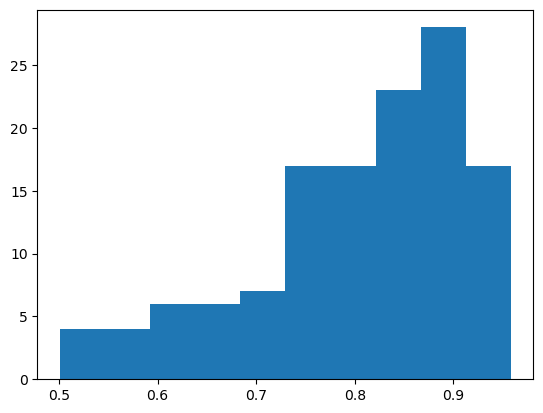

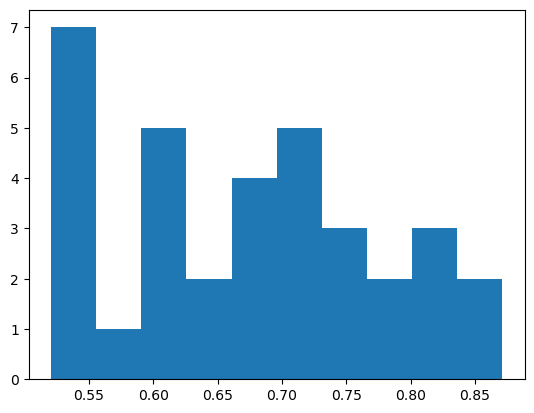

In [96]:
trueneg = predictions_vA2[np.logical_and(predictions_vA2["prediction"] == 0, predictions_vA2["prediction"] == predictions_vA2["label"])]["negative"]
plt.hist(trueneg)
plt.show()

falseneg = predictions_vA2[np.logical_and(predictions_vA2["prediction"] == 0, predictions_vA2["prediction"] != predictions_vA2["label"])]["negative"]
plt.hist(falseneg)
plt.show()

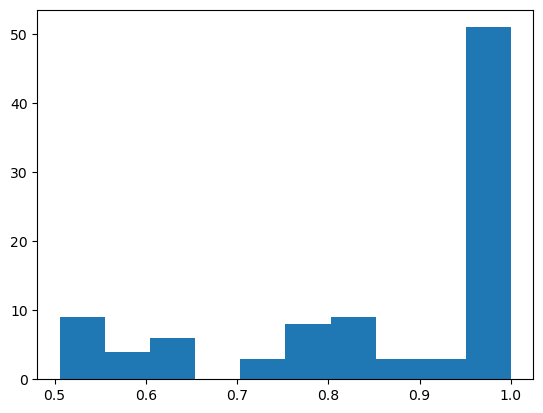

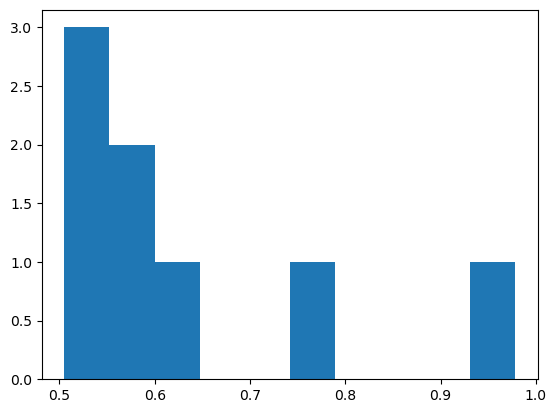

In [95]:
truepos = predictions_vA2[np.logical_and(predictions_vA2["prediction"] == 1, predictions_vA2["prediction"] == predictions_vA2["label"])]["positive"]
plt.hist(truepos)
plt.show()

falsepos = predictions_vA2[np.logical_and(predictions_vA2["prediction"] == 1, predictions_vA2["prediction"] != predictions_vA2["label"])]["positive"]
plt.hist(falsepos)
plt.show()

## Comparison with known structure

In [6]:
dfpred_vA1 = pd.merge(
    left=wrong_predictions_vA1,
    right=dataAF["solved structure"], 
    how='inner',
    left_index = True,
    right_index = True
)
dfpred_vA1 = pd.merge(
    left=dfpred_vA1,
    right=measureSolved[["hbonds", "salt_bridges", "hydrophobic_interactions", "buried_area", "min_distance"]], 
    how='left',
    left_on = ["solved structure"],
    right_index = True
)
c = list(dfpred_vA1.columns)
c.sort()
c.remove("label")
c.remove("prediction")
c.remove("positive")
c.remove("negative")
c.insert(0, "label")
c.insert(1, "prediction")
c.insert(2, "positive")
c.insert(3, "negative")

dfpred_vA1 = dfpred_vA1[c]

display(dfpred_vA1)


,label,prediction,positive,negative,buried_area_x,buried_area_y,chainA_intf_avg_plddt,chainA_length,chainB_intf_avg_plddt,chainB_length,...,min_distance_y,model_confidence,num_atom_atom_contact,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,pDockQ,salt_bridges_x,salt_bridges_y,solved structure
MLIG_SH3_2_1CKA.DTRG_NLS_Bipartite_1_1PJM_ranked_0,0,0,0.493210,0.506790,939.403,NaN,96.503333,460,47.273335,6,...,NaN,0.672614,250,21,6,31,0.128674,1,NaN,None
MLIG_DLG_GKlike_1_3WP0.DTRG_ER_FFAT_1_2RR3_ranked_0,0,0,0.489465,0.510535,920.748,NaN,95.142143,125,68.821111,9,...,NaN,0.708754,223,14,9,30,0.187396,1,NaN,None
MDEG_SCF_COI1_1_3OGL.DLIG_CaM_IQ_9_2IX7_ranked_1,0,0,0.481856,0.518144,1823.567,NaN,68.922000,139,47.594616,18,...,NaN,0.398070,384,25,13,45,0.040909,6,NaN,None
MLIG_deltaCOP1_diTrp_1_5FJX.DLIG_CAP-Gly_1_2PZO_ranked_2,0,0,0.481330,0.518670,583.829,NaN,95.422727,46,62.094999,6,...,NaN,0.400048,169,11,4,16,0.093906,0,NaN,None
MLIG_LIR_Nem_3_5AZG.DLIG_ULM_U2AF65_1_1O0P_ranked_1,0,0,0.474458,0.525542,859.820,NaN,95.420667,104,75.908001,5,...,NaN,0.774361,290,15,5,25,0.112257,0,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOC_PP1_MyPhoNE_1_1S70_ranked_2,1,1,0.523867,0.476133,1184.398,859.123,91.066000,299,47.313750,8,...,5.318,0.608114,285,15,8,30,0.056849,1,3.0,1S70
LIG_WD40_WDR5_WIN_2_4CY3_ranked_3,1,1,0.520023,0.479977,990.388,1136.192,88.749999,312,39.466000,7,...,4.691,0.656029,238,21,5,32,0.098805,4,2.0,4CY3
LIG_Clathr_ClatBox_2_1UTC_ranked_1,1,1,0.519262,0.480738,825.921,909.018,92.944117,328,55.263334,6,...,6.008,0.711074,212,17,6,27,0.093599,1,3.0,1UTC
LIG_Rb_LxCxE_1_1GH6_ranked_1,1,1,0.512861,0.487139,1696.524,1239.433,84.634583,123,30.665333,17,...,5.796,0.354527,442,24,15,51,0.071754,3,0.0,1GH6


In [7]:
x = dfpred_vA1[dfpred_vA1["label"] != dfpred_vA1["prediction"]]
x

,label,prediction,positive,negative,buried_area_x,buried_area_y,chainA_intf_avg_plddt,chainA_length,chainB_intf_avg_plddt,chainB_length,...,min_distance_y,model_confidence,num_atom_atom_contact,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,pDockQ,salt_bridges_x,salt_bridges_y,solved structure
MTRG_ENDOCYTIC_2_1BXX.DTRG_ER_FFAT_1_2RR3_ranked_0,0,1,0.982533,0.017467,892.117,NaN,96.376666,125,87.002501,4,...,NaN,0.867728,250,15,4,26,0.168446,0,NaN,None
MLIG_PTB_Apo_2_1NTV.DDOC_MAPK_JIP1_4_4H3B_ranked_0,0,1,0.715937,0.284063,1048.554,NaN,91.326876,356,70.028572,8,...,NaN,0.814851,321,16,7,31,0.117514,2,NaN,None
MLIG_NBox_RRM_1_2KXH.DLIG_PAM2_1_1JGN_ranked_0,0,1,0.629302,0.370698,874.912,NaN,91.014616,73,69.871250,11,...,NaN,0.601829,227,13,8,26,0.104666,0,NaN,None
MLIG_deltaCOP1_diTrp_1_5FJX.DLIG_CAP-Gly_1_2PZO_ranked_4,0,1,0.582798,0.417202,577.366,NaN,95.084545,46,57.487499,6,...,NaN,0.371831,174,11,4,15,0.050722,0,NaN,None
MLIG_EVH1_3_1MKE.DLIG_LSD1_SNAG_1_2Y48_ranked_0,0,1,0.540254,0.459746,1082.983,NaN,93.899545,543,30.985000,6,...,NaN,0.656162,331,22,6,31,0.119379,0,NaN,None
MLIG_FXI_DFP_1_5EOD.DLIG_BIR_III_3_1JD5_ranked_3,0,1,0.538806,0.461194,628.664,NaN,96.877501,72,75.013334,5,...,NaN,0.610782,159,8,3,14,0.084436,2,NaN,None
MLIG_deltaCOP1_diTrp_1_5FJX.DLIG_CAP-Gly_1_2PZO_ranked_3,0,1,0.507533,0.492467,543.132,NaN,94.977273,46,57.825999,6,...,NaN,0.372302,161,11,5,18,0.060740,0,NaN,None
LIG_GYF_1L2Z_ranked_4,1,0,0.494789,0.505211,728.940,808.658,88.051000,62,46.638750,9,...,6.490,0.399613,199,10,8,23,0.042417,0,1.0,1L2Z
LIG_ARL_BART_1_4ZI2_ranked_3,1,0,0.488209,0.511791,1148.728,1247.161,81.625334,131,47.270000,8,...,5.218,0.519727,230,15,8,28,0.068990,0,4.0,4ZI2
LIG_CNOT1_NIM_1_4CQO_ranked_2,1,0,0.465655,0.534345,574.926,855.753,69.043333,437,24.302500,10,...,5.279,0.384883,174,9,4,14,0.021830,0,0.0,4CQO


In [14]:
true_predictions = dfpred_vA1[dfpred_vA1["label"] == dfpred_vA1["prediction"]]
true_predictions_truepos = true_predictions[true_predictions["prediction"] == 1]
true_predictions_trueneg = true_predictions[true_predictions["prediction"] == 0]
wrong_predictions = dfpred_vA1[dfpred_vA1["label"] != dfpred_vA1["prediction"]]
wrong_predictions_falseneg = wrong_predictions[wrong_predictions["prediction"] == 0]
wrong_predictions_falsepos = wrong_predictions[wrong_predictions["prediction"] == 1]

(130, 27)


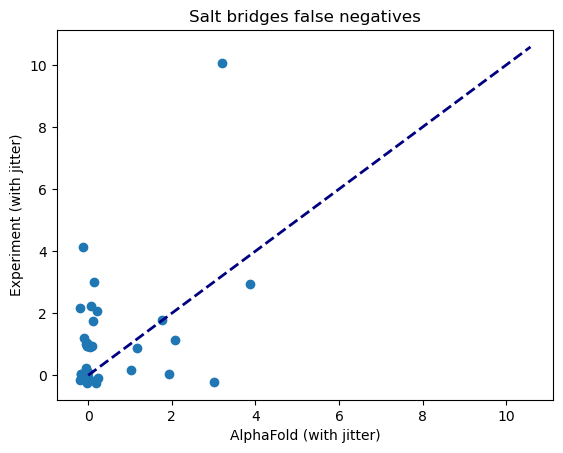

In [8]:
rnd = np.random.default_rng(seed=2501)


plt.title("Salt bridges false negatives")
plt.scatter(wrong_predictions_falseneg["salt_bridges_x"] + 0.5*rnd.random(wrong_predictions_falseneg["salt_bridges_x"].shape[0])-0.25, wrong_predictions_falseneg["salt_bridges_y"] + 0.5*rnd.random(wrong_predictions_falseneg["salt_bridges_y"].shape[0])-0.25)
max = np.max([plt.xlim()[1], plt.ylim()[1]])

plt.plot([0, max], [0, max], color='navy', lw=2, linestyle='--')
plt.xlabel("AlphaFold (with jitter)")
plt.ylabel("Experiment (with jitter)")
plt.show()

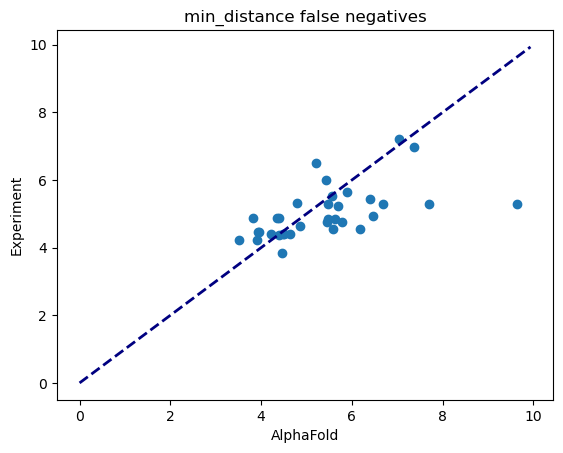

In [9]:
plt.title("min_distance false negatives")
plt.scatter(wrong_predictions_falseneg["min_distance_x"], wrong_predictions_falseneg["min_distance_y"])
max = np.max([plt.xlim()[1], plt.ylim()[1]])

plt.plot([0, max], [0, max], color='navy', lw=2, linestyle='--')
plt.xlabel("AlphaFold")
plt.ylabel("Experiment")
plt.show()

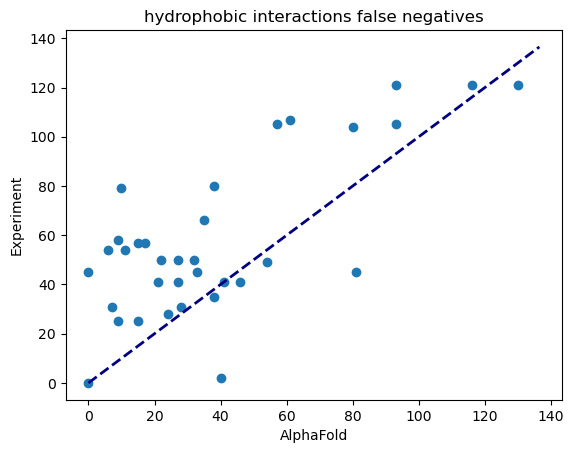

In [32]:
plt.title("hydrophobic interactions false negatives")
plt.scatter(wrong_predictions_falseneg["hydrophobic_interactions_x"], wrong_predictions_falseneg["hydrophobic_interactions_y"])
max = np.max([plt.xlim()[1], plt.ylim()[1]])

plt.plot([0, max], [0, max], color='navy', lw=2, linestyle='--')
plt.xlabel("AlphaFold")
plt.ylabel("Experiment")
plt.show()

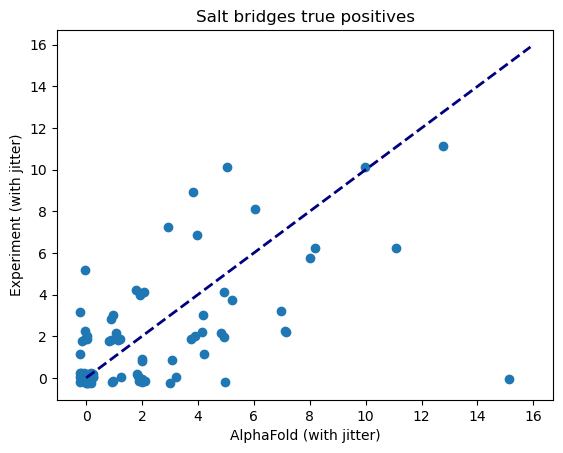

In [20]:
rnd = np.random.default_rng(seed=2501)


plt.title("Salt bridges true positives")
plt.scatter(true_predictions_truepos["salt_bridges_x"] + 0.5*rnd.random(true_predictions_truepos["salt_bridges_x"].shape[0])-0.25, true_predictions_truepos["salt_bridges_y"] + 0.5*rnd.random(true_predictions_truepos["salt_bridges_y"].shape[0])-0.25)
max = np.max([plt.xlim()[1], plt.ylim()[1]])

plt.plot([0, max], [0, max], color='navy', lw=2, linestyle='--')
plt.xlabel("AlphaFold (with jitter)")
plt.ylabel("Experiment (with jitter)")
plt.show()

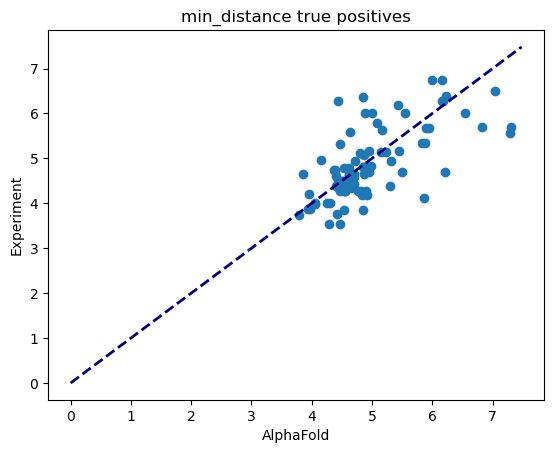

In [18]:
plt.title("min_distance true positives")
plt.scatter(true_predictions_truepos["min_distance_x"], true_predictions_truepos["min_distance_y"])
max = np.max([plt.xlim()[1], plt.ylim()[1]])

plt.plot([0, max], [0, max], color='navy', lw=2, linestyle='--')
plt.xlabel("AlphaFold")
plt.ylabel("Experiment")
plt.show()

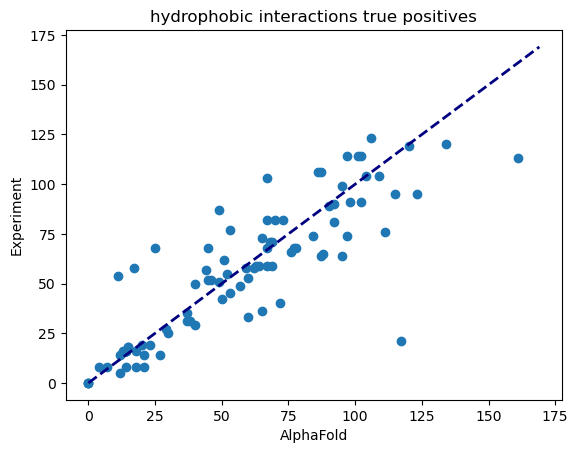

In [17]:
plt.title("hydrophobic interactions true positives")
plt.scatter(true_predictions_truepos["hydrophobic_interactions_x"], true_predictions_truepos["hydrophobic_interactions_y"])
max = np.max([plt.xlim()[1], plt.ylim()[1]])

plt.plot([0, max], [0, max], color='navy', lw=2, linestyle='--')
plt.xlabel("AlphaFold")
plt.ylabel("Experiment")
plt.show()